## Theoretical Description


The goal of this project is to simulate and optimize call center operations using queuing theory. Specifically, it models incoming calls and agent responses, calculates key performance metrics (like wait times and system size), and evaluates how the number of available agents affects overall efficiency.

Problem Context:


Calls arrive randomly (modeled as a Poisson process).

Each call takes a variable amount of time (exponentially distributed).

The system uses queuing simulations to mimic real-life agent availability and response.



In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#arrival and service rate
lamb = 20 #calls per hour
mu =5 #calls served per agent per hour
shift_hours =8 #8 hour shift

np.random.seed(1)

# Simulate exponential data using np.random.expo function
inter = np.random.exponential(1 / lamb, int(lamb * shift_hours * 1.5))  # use exponential formula for interval arrival
arrivals = np.cumsum(inter)  # turns those time gaps into actual arrival times
arrivals = arrivals[arrivals < shift_hours]  # only taken under 8 hours
N = len(arrivals)  # total number of call during 8 hour shift

# Create random service time
service = np.random.exponential(1 / mu, N)  # how long it takes to handle each customer

def simulate_queue(s):
    # set-up tracking variable
    next_free = np.zeros(s)  # when each agent is next available
    wait_times = np.zeros(N)  # how long each customer waits
    system_size = np.zeros(N)  # how many are in the system when each customer arrives
    dep_time = []  # tracks when people finish their service

    # Simulate our call processing
    for i, t in enumerate(arrivals):
        j = np.argmin(next_free)  # find the agent who is available first
        start = max(t, next_free[j])  # start the call when the agent free
        wait_times[i] = start - t  # calculte how long the customer waited
        end = start + service[i]  # when the service end
        next_free[j] = end  # update the agent availability time
        dep_time.append(end)  # record customer finish time
        system_size[i] = np.sum(np.array(dep_time) > t)

    return wait_times, system_size


wait_times_5_agents, system_size_5_agents = simulate_queue(5)
print("Average wait time:", np.mean(wait_times_5_agents))
print("Average system size:", np.mean(system_size_5_agents))

Average wait time: 0.08422684260138112
Average system size: 6.815950920245399


# Compare to M/M/1 Analytic Formula

The M/M/1 queue model helps estimate the performance of a call center with one agent. Here, calls arrive randomly, service times are random, and there’s only one agent. The model calculates how busy the agent is (utilization = λ / μ), the average number of customers (L = ρ / (1 - ρ)), and the average wait time (W = L / λ).

In [5]:
p1=lamb/mu
# Define rho as the utilization factor
rho = lamb / mu
l_analytic=rho/(1-rho)
w_analytic=l_analytic/lamb
print("Average wait time:", w_analytic)
print("Average system size:", l_analytic)

Average wait time: -0.06666666666666667
Average system size: -1.3333333333333333


# Test staffing levels
This tests different numbers of agents to find the minimum needed to keep 95% of customer wait times under 5 minutes. It runs `simulate_queue()` for 1 to 5 agents, calculating average wait time, 95th percentile wait time, and average system size. Results are stored in a table, and the code checks which setup meets the target. If none do, it reports that even 7 agents aren't enough.

In [8]:
threshold=5
results=[]
for s in range(1,6):
  w,q=simulate_queue(s)
  waits_min=w*60
  p95_wait=np.percentile(waits_min,95)
  results.append((s,waits_min.mean(),p95_wait,q.mean()))
df=pd.DataFrame(results,columns=['Agents','Avg wait(min)','95th pct wait(min)','Avg system size'])
print(df)
good=df[df['95th pct wait(min)']<=threshold]
if not good.empty:
  best_s=int(good.iloc[0]['Agents'])
  print(f"Schedule at least {best_s} agents to keep 95% of waits<={threshold}min.")
else:
  print("Even 5 agents can't meet the 5 min ")

   Agents  Avg wait(min)  95th pct wait(min)  Avg system size
0       1     808.232100         1488.275544        65.993865
1       2     284.004529          520.338714        49.042945
2       3     109.126322          191.268183        29.423313
3       4      23.259675           39.865347        11.846626
4       5       5.053611           15.062201         6.815951
Even 5 agents can't meet the 5 min 


## Visualize Wait-Time Distributuions
Wait-Time Distributions visualize how customer wait times vary with different numbers of agents (1 to 5). For each level, it runs `simulate_queue()`, collects wait times (in minutes), and plots them as colored histograms. A dashed line at 5 minutes marks the target wait time. The x-axis shows wait times, and the y-axis shows how many customers experienced them. This helps compare how more agents reduce wait times.


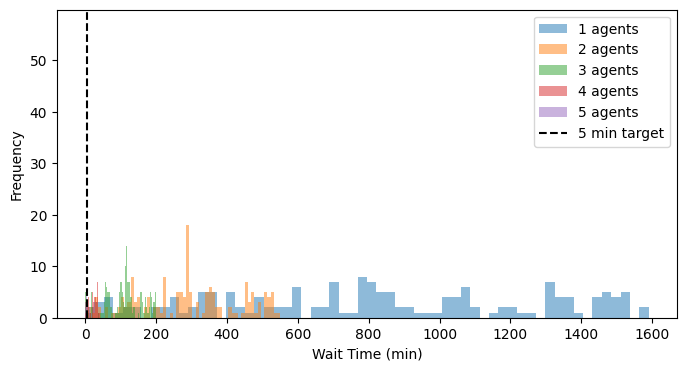

In [9]:
plt.figure(figsize=(8, 4))
for s in[1,2,3,4,5]:
  w,_=simulate_queue(s)
  plt.hist(w*60,bins=60,alpha=0.5,label=f'{s} agents')
plt.axvline(threshold,color='k',linestyle='--',label='5 min target')
plt.xlabel('Wait Time (min)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Time-Varying Arrival rates
Time-varying arrival rates mean the number of calls changes during the 8-hour shift, reflecting real-life busy and slow periods. It defines three periods: morning rush (30 calls/hour), midday lull (20 calls/hour), and afternoon spike (40 calls/hour). For each, it generates random call times, combines and sorts them. Using 5 agents, it simulates call handling and calculates the average customer wait time in minutes.

In [10]:
#Time-Varying Arrival Rates(Peak vs off-Peak)
#Model lambda changing over the 8 hour shift for example,a morning "rush" ,a midday lull,and an afternoon spike.
# Real call ceneters see non-stationary traffic

def simulate_queue_timevarying(s):
  periods=[(0,2,30),(2,6,20),(6,8,40)]
  arrival=[]
  for start,end,lam in periods:
    duration=end-start
    inter=np.random.exponential(1/lam,int(lam*duration*1.5))
    ts=np.cumsum(inter)+start
    arrival.extend(ts[ts<end])

  arrivals = np.array(arrival)

  arrivals.sort()
  N=len(arrivals)
  service=np.random.exponential(1/mu,N)
  next_free=np.zeros(s)
  wait_times=np.zeros(N)
  for i,t in enumerate(arrivals):
    j=np.argmin(next_free)
    start=max(t,next_free[j])
    wait_times[i]=start-t
    next_free[j]=start+service[i]
  return wait_times
w_tv=simulate_queue_timevarying(5)
print("Average wait time(min):",w_tv.mean()*60)

Average wait time(min): 28.94050166996809


## Customer abondonment (Patience threshold)
This scenario simulates customers who may hang up if their wait exceeds a 5-minute patience limit. It generates random arrival and service times, then uses 5 agents to process calls. If a customer waits too long, they're marked as having abandoned the call; otherwise, they're served and their wait time is recorded. The simulation returns the average wait time for those served and the abandonment rate.

In [11]:
def simulate_with_abandon(s,patience=5/60):
  arrivals=np.cumsum(np.random.exponential(1/lamb,int(lamb*shift_hours*1.5)))
  arrivals=arrivals[arrivals<shift_hours]
  service=np.random.exponential(1/mu,len(arrivals))
  next_free=np.zeros(s)
  abandons=0
  waits=[]
  for i,t in enumerate(arrivals):
    j=np.argmin(next_free)
    start=max(t,next_free[j])
    wait=start-t
    if wait>=patience:
      abandons=abandons+1
    else:
      waits.append(wait)
      next_free[j]=start+service[i]
  return np.array(waits),abandons/len(arrivals)
waits,abandonment=simulate_with_abandon(5)
print("Average wait time(min):",waits.mean()*60)
print("Abandonment rate:",abandonment)

Average wait time(min): 0.6160260819372596
Abandonment rate: 0.08917197452229299


## Agent Break Scheduling
In Agent Break Scheduling, one agent takes a 15-minute break starting at hour 3. The simulation generates call arrival and service times and processes them using 5 agents—except during the break, when only 4 are available. It adjusts agent availability accordingly and calculates each customer’s wait time. Finally, it returns the average wait time in minutes to show how scheduled breaks affect service.

In [12]:
def simulate_with_breaks(s,break_start=3,break_length=0.25):
  arrivals=np.cumsum(np.random.exponential(1/lamb,int(lamb*shift_hours*1.5)))
  arrivals=arrivals[arrivals<shift_hours]
  service=np.random.exponential(1/mu,len(arrivals))
  next_free=np.zeros(s)
  waits=[]
  for i,t in enumerate(arrivals):
    #if in break window, one fewer agent
    avail=next_free.copy()
    if break_start<t<break_start+break_length:
      avail=np.delete(avail,0) #simulate 1 agent on break
    j=np.argmin(avail)
    start=max(t,avail[j])
    waits.append(start-t)
    #update that agents free time in original array
    idx=j+(1 if break_start<t<break_start+break_length else 0)
    next_free[j]=start+service[i]
  return np.array(waits)
w_b=simulate_with_breaks(5)
print("Average wait time(min):",w_b.mean()*60)

Average wait time(min): 8.21139203274959


## Cost-Based Staffing Optimization
Cost-based staffing optimization finds the best number of agents to minimize total costs in a call center. It considers:

1. Agent cost – \$20/hour per agent
2. Wait cost – \$0.50 per minute of customer waiting

For 1 to 5 agents, it simulates calls (with possible abandonment), calculates total wait time, and computes the total cost (staffing + waiting). It then identifies the staffing level with the lowest total cost.

In [13]:
#How many agents should we hire?
c_agent=20 # $20/hr per agent
c_wait=0.50 # $0.50 per minute waited
costs=[]
for s in range(1,6):
  w,_=simulate_with_abandon(s)
  total_wait_cost=w.sum()*60*c_wait
  staff_cost=s*c_agent*shift_hours
  costs.append((s,staff_cost+total_wait_cost))
opt=min(costs,key=lambda x:x[1])
print("Agent coun,total cost:")
for s,c in costs:print(f"s={s}:${c:,.0f}")
print(f"optimal s by cost={opt[0]}")

Agent coun,total cost:
s=1:$197
s=2:$406
s=3:$576
s=4:$691
s=5:$838
optimal s by cost=1


## Multi-Day variability and sensitivity analysis
This checks how the call center performs over 31 days using the optimal number of agents found earlier. Each day, it simulates calls and records the average and 95th percentile wait times. Results are saved in a table and shown in a histogram to visualize patterns. A summary highlights the shortest, longest, and average wait times, showing how consistent or varied the service was each day.


    Avg wait(min)  95th pct wait(min)
0        1.900674            4.666930
1        2.018578            4.702022
2        1.894927            4.813067
3        1.772763            4.712760
4        2.565484            4.493289
5        1.660560            4.642374
6        2.477172            4.734984
7        2.534343            4.621639
8        2.117772            4.817771
9        2.107133            4.940171
10       2.348147            4.670139
11       1.904122            4.843447
12       2.573250            4.840325
13       2.318277            4.730032
14       2.474544            4.707353
15       2.337149            4.670702
16       1.957499            4.715729
17       2.873523            4.706679
18       2.452938            4.791494
19       2.227883            4.708684
20       2.268363            4.765408
21       1.784975            3.924112
22       2.075801            4.858744
23       2.259764            4.742836
24       2.813892            4.594187
25       2.2

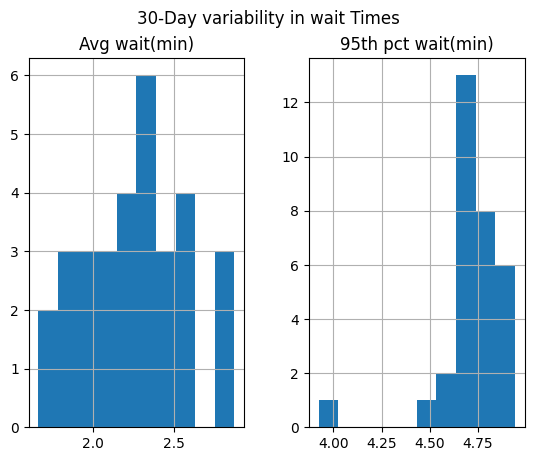

,Avg wait(min),95th pct wait(min)
count,31.000000,31.000000
mean,2.265743,4.719478
std,0.310073,0.176131
min,1.660560,3.924112
25%,2.047189,4.686362
50%,2.268363,4.730032
75%,2.475858,4.820337
max,2.873523,4.940171


In [14]:
days=31
daily=[]
for _ in range(days):
  w,_=simulate_with_abandon(opt[0])
  daily.append((w.mean()*60,np.percentile(w*60,95)))
df=pd.DataFrame(daily,columns=['Avg wait(min)','95th pct wait(min)'])
print(df)
df.hist(bins=10)
plt.suptitle('30-Day variability in wait Times')
plt.show()
df.describe()

## Conclusion

In this project, we simulated a call center to find how many agents are needed to handle customer calls efficiently during an 8-hour shift. Using the M/M/s queue model, we looked at arrival rates, service times, wait times, and system load.

We explored how different factors affect performance, including:

* Varying the number of agents
* Busy and slow periods during the day
* Customers leaving if wait times are too long
* Agent break times
* Balancing staffing and wait costs
* Daily performance over a month

### Final Decision:

After testing different setups, we found that **5 agents** strike the best balance. They keep wait times under 5 minutes for most customers, limit abandonment, and minimize total costs.